In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
import os
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout,Flatten,Dense,Input
from keras import Sequential
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.constants import lb
import numpy as np
import cv2 as cv

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
train_dataset = "C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\train_preprocessed"
val_dataset = "C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\val_preprocessed"
test_dataset = "C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test"

In [17]:
train_images=list(paths.list_images(train_dataset))
val_images=list(paths.list_images(val_dataset))
test_images=list(paths.list_images(test_dataset))

In [ ]:
print(train_images)

In [6]:
print(test_images)

['C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003175L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003175R.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003316L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003815L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003815R.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9004184R.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9006407L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9009927L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9009957L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\

In [13]:
print(val_images)

[]


In [37]:
train_data=[]
train_labels=[]
val_data=[]
val_labels=[]
test_data=[]
test_labels=[]

for i in train_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    train_labels.append(label)
    image = load_img(i,target_size=(224,224))
    image = img_to_array(image)
    #image = preprocess_input(image)
    train_data.append(image)

for i in val_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    val_labels.append(label)
    image = load_img(i,target_size=(224,224))
    image = img_to_array(image)
    #image = preprocess_input(image)
    val_data.append(image)

for i in test_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    test_labels.append(label)
    image = load_img(i,target_size=(224,224))
    image = img_to_array(image)
    #image = preprocess_input(image)
    test_data.append(image)


In [39]:
print(len(val_data))
print(len(val_labels))

1652
1652


In [38]:

train_data=np.array(train_data, dtype='float32')
train_labels=np.array(train_labels)

val_data=np.array(val_data, dtype='float32')
val_labels=np.array(val_labels)

test_data=np.array(test_data, dtype='float32')
test_labels=np.array(test_labels)


In [55]:
print(val_labels)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [40]:
#lb = LabelBinarizer()
#labels = lb.fit_transform(labels)
train_labels = to_categorical(train_labels)

val_labels = to_categorical(val_labels)

test_labels = to_categorical(test_labels)


In [33]:
print(len(val_labels))
print(len(val_data))

1652
3308


In [ ]:
## Splitting of Data

#train_X,test_X,train_Y,test_Y = train_test_split(data,labels,test_size=0.20,random_state=10,stratify=labels)

In [41]:

aug=ImageDataGenerator(

                       )

In [42]:
input_shape = (224,224,3)

In [43]:
# Build Model BEST MODEL
input_image = Input(shape=input_shape)
# 1st Conv layer


In [56]:
lr=0.0005
Epochs=100
BS=60



In [58]:

opt=Adam(learning_rate=lr,decay=lr/Epochs)
model = tf.keras.applications.MobileNetV3Small()
model = Sequential([model,Flatten(),Dense(100),Dense(64),Dropout(0.5),Dense(5, activation='softmax')])#1024,64,0.2
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [59]:
history=model.fit(
aug.flow(train_data,train_labels,batch_size=BS),
steps_per_epoch=len(train_data)//BS,
validation_data=(val_data,val_labels),
validation_steps=len(val_data)//BS,
epochs=Epochs

)

Epoch 1/100
192/192 [==============================] - 27s 120ms/step - loss: 1.2517 - accuracy: 0.4862 - val_loss: 1.4534 - val_accuracy: 0.4219
Epoch 2/100
192/192 [==============================] - 22s 111ms/step - loss: 0.9973 - accuracy: 0.5883 - val_loss: 1.2006 - val_accuracy: 0.4776
Epoch 3/100
192/192 [==============================] - 22s 112ms/step - loss: 0.8981 - accuracy: 0.6231 - val_loss: 1.1086 - val_accuracy: 0.5521
Epoch 4/100
192/192 [==============================] - 23s 113ms/step - loss: 0.8153 - accuracy: 0.6571 - val_loss: 1.6287 - val_accuracy: 0.4540
Epoch 5/100
192/192 [==============================] - 23s 112ms/step - loss: 0.7443 - accuracy: 0.6976 - val_loss: 1.3323 - val_accuracy: 0.5115
Epoch 6/100
192/192 [==============================] - 23s 113ms/step - loss: 0.6748 - accuracy: 0.7282 - val_loss: 1.4387 - val_accuracy: 0.4946
Epoch 7/100
192/192 [==============================] - 22s 111ms/step - loss: 0.6155 - accuracy: 0.7558 - val_loss: 1.2588 -

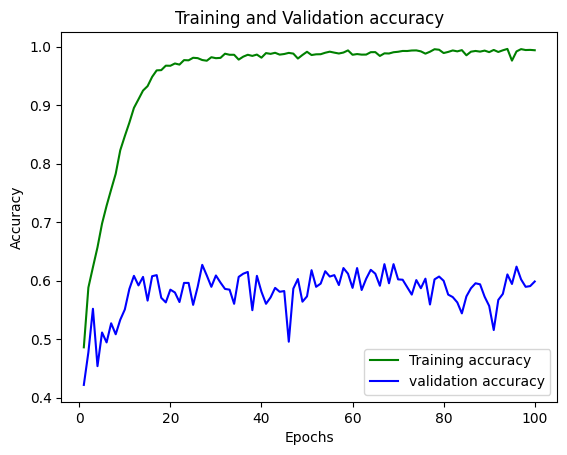

In [60]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']

epochs = range(1,101)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig("accuracy.png")

In [ ]:
model.save('./trained_model_mobileNet.h5')

In [52]:



predict=model.predict(aug.flow(test_data), batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_labels.argmax(axis=1) ,predict, target_names=["0", "1", "2", "3", "4"]))

52/52 [==============================] - 3s 23ms/step
              precision    recall  f1-score   support

           0       0.37      0.15      0.21       639
           1       0.19      0.31      0.23       296
           2       0.25      0.32      0.28       447
           3       0.15      0.22      0.18       223
           4       0.00      0.00      0.00        51

    accuracy                           0.23      1656
   macro avg       0.19      0.20      0.18      1656
weighted avg       0.26      0.23      0.22      1656



In [53]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_true=test_labels.argmax(axis=1), y_pred=predict)

AxesSubplot(0.125,0.11;0.775x0.77)


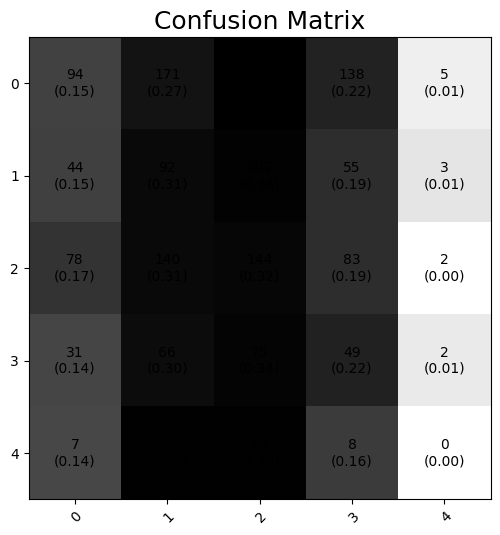

In [54]:
import matplotlib
fig, ax = plot_confusion_matrix(conf_mat=cm,
        figsize=(6, 6),
        class_names = ["0", "1","2","3","4"],
        show_absolute=True,
        show_normed=True,
         cmap='Greys',

         norm_colormap=matplotlib.colors.LogNorm( ))

plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
#plt.savefig("cm.png")
print(ax)

In [ ]:
img = tf.keras.utils.load_img(
    "C:\\Users\\T-GAMER\\Downloads\\not_mask.png", target_size=(96, 96)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = preprocess_input(img_array)
mask, withoutMask=model.predict(img_array)[0]

            #determine the class label and color we will use to draw the bounding box and text
label, score =('Mask', mask) if mask>withoutMask else ('No Mask', withoutMask)
print((mask, withoutMask))
print(
    "This image most likely belongs to {} with a {} percent confidence."
    .format(label, score)
)
